<a href="https://colab.research.google.com/github/MandbeZ/TFM_sequia/blob/main/notebooks/4_2_1_Modelo_SerieTemporal_LSTM_SPI_SPEI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install tensorflow==2.1
%pip install keras-tcn
%pip install numpy==1.19.2
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 421.8 MB 20 kB/s 
     |████████████████████████████████| 448 kB 53.9 MB/s 
     |████████████████████████████████| 50 kB 6.8 MB/s 
     |████████████████████████████████| 3.8 MB 39.5 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=2217ac4e00b918e5954fafb3d8a867d9a91c06c65213465e7165cd83cd52eb52
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting un

In [1]:
from warnings import simplefilter
simplefilter(action="ignore", category=RuntimeWarning)
simplefilter(action="ignore", category=FutureWarning)

## Importar librerías básicas

In [2]:
import numpy as np
import pandas as pd
import datetime
import random
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

## Importar librerías de Tensor Flow y Keras

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, LSTM, Input #, GRU
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dropout
from tcn import TCN
from collections import defaultdict
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from math import sqrt
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


## Definición de Funciones Básicas

In [16]:
'''Colores para los plot'''
colores = plt.get_cmap('Set1', 30)

def cargar_datos(archivo, lista_cluster, c):
    data = pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/spi_spei/' + archivo,  sep = ',', parse_dates=True)
    estaciones = lista_cluster[lista_cluster['cluster'] == c]
    nom_cols = [col for est in estaciones['id'] for col in data.columns if str(est) in col]
    nom_cols.append('fecha')
    datos = data[nom_cols]
    return datos

'''Llevar la  fecha a índice, configurar como periodo'''
def procesa_datos(data):
    data['fecha'] = pd.to_datetime(data['fecha'])
    data = data.dropna()
    data = data.set_index('fecha')
    data.index = data.index.to_period('M')
    return data

'''Se normalizan los datos Min-Max: [0,1]'''
def normalizar_datos(data,param):
    return (data - param['min']) / ( param['max'] - param['min'])

def plotear(x, y, y_pred=None):
  fig, ax = plt.subplots(1,1, figsize=(15,5))
  ax.plot(x, 'o-',  c=colores(1), markersize=3.5, label='Entrenamiento(Train)')
  ax.plot([m for m in range(x.shape[0],x.shape[0]+y.shape[0])], y, 'x-', c=colores(5), markersize=3.5, label='Validación(Test)')
  if y_pred is not None:
    ax.plot([m for m in range(x.shape[0],x.shape[0]+y.shape[0])], y_pred, 'o-', c=colores(8), markersize=3.5, label='Predicción(Pred)')
  ax.legend()

def evaluar(test,pred):
  mape = mean_absolute_percentage_error(test, pred)
  mae = mean_absolute_error(test, pred)  
  mse = mean_squared_error(test, pred) # square=True MSE , false RMSE
  rmse = sqrt(mean_squared_error(test, pred)) # square=True MSE , false RMS
  return [mae,mape,rmse,mse]


# Red Recurrente LSTM con tres  capas

In [20]:
'''Función para el cálculo de LSTM con 3 capas'''
def modelo_lstm3(lind,lesc,cluster,lclu,ventana,epocas,x1,x2,x3,tbatch,error):
  # Cargar datos
  datos = cargar_datos('indices_'+lind+str(lesc)+'.csv', cluster,lclu)
  datos_p = procesa_datos(datos)
  if(lesc==12):
    '''Diferenciar las series'''
    datos_p_d = datos_p.diff()
    datos_p=datos_p_d.dropna()
  '''División del DataSet en Entramiento y test'''
  train = datos_p.iloc[:-hpred]
  test = datos_p.iloc[-hpred:]

  '''Normalizar datos'''
  s_train = []
  for i in list(train):
      s_train.append(train[i].tolist())

  s_test = []
  for i in list(test):
      s_test.append(test[i].tolist())

  s_train = np.asarray(s_train)
  s_test = np.asarray(s_test)

  train_norm = []
  #Obtener los parámetros de normalización de train
  lista_param = []

  for s in s_train:
    params = {}
    params['max'] = s.max()
    params['min'] = s.min()
    lista_param.append(params)
    norm = normalizar_datos(s, params)
    train_norm.append(norm)
  # Aplicar los parámetros de normalización al test 
  test_norm = []
  for x, s in enumerate(s_test):
    params = lista_param[x]
    norm = normalizar_datos(s,params)
    test_norm.append(norm)
  test_norm[len(test_norm)-1]

  '''ventana movil'''
  x_train, y_train = [], []
  x_test, y_test = [], []

  for i, ts in enumerate(train_norm):
    # Train data
    ts_x_train, ts_y_train = [], []
    for j in range(0, ts.shape[0] - hpred + 1):
        indices = range(j - ventana, j, 1)
        
        ts_x_train.append(np.reshape(ts[indices], (ventana, 1)))
        ts_y_train.append(ts[j:j + hpred])
    x_train.extend(np.asarray(ts_x_train))
    y_train.extend(np.asarray(ts_y_train))
    # Test data
    ts_x_test = np.reshape(np.asarray(ts[-ventana:]), (ventana, 1))
    ts_y_test=  test_norm[i]
    x_test.extend(np.asarray([ts_x_test]))
    y_test.extend(np.asarray([ts_y_test]))
    
  x_train, y_train = np.asarray(x_train), np.asarray(y_train)
  x_test, y_test = np.asarray(x_test), np.asarray(y_test, dtype='float32')

  # Fijar la semilla para los experimentos
  tf.keras.backend.clear_session()
  np.random.seed(1)
  tf.random.set_seed(1)
  random.seed(1)

  print('LSTM3_'+lind+str(lesc)+'_c'+str(lclu)+'_v'+str(ventana)+'_e'+str(epocas)+'_b'+str(tbatch)+'.'+str(x1)+'.'+str(x2)+'.'+str(x3))
  inp = Input(shape=x_train.shape[-2:])
  # x = tf.keras.layers.Bidirectional(LSTM(x1, return_sequences=True))(inp)
  # x = tf.keras.layers.Bidirectional(LSTM(x2, return_sequences=False))(x)
  x = LSTM(x1, return_sequences=True)(inp)
  x = LSTM(x2, return_sequences=False)(x)
  x = Dense(x3)(x)
  x = Dense(hpred)(x)
  model = keras.Model(inputs=inp, outputs=x)
  model.compile(optimizer='adam', loss=error)
  # print(model.summary())

  history = model.fit(x_train, y_train,
            batch_size=tbatch,
            epochs=epocas,
            verbose=1,
            validation_data=(x_test, y_test))

  nom_columna = 'LSTM3'+lind+str(lesc)+'_c'+str(lclu)+'_v'+str(ventana)+'_e'+str(epocas)+'_b'+str(tbatch)+'.'+str(x1)+'.'+str(x2)+'.'+str(x3)
  # Graficas de entrenamiento y validación
  plt.figure()
  # plt.title('LSTM3_'+lind+str(lesc)+'_c'+str(lclu)+'_v'+str(ventana)+'_e'+str(epocas)+'_b'+str(tbatch)+'.'+str(x1)+'.'+str(x2))
  plt.title('LSTM3_'+lind+str(lesc)+'_c'+str(lclu)+'_v'+str(ventana)+'_e'+str(epocas)+'_b'+str(tbatch)+'.'+str(x1)+'.'+str(x2)+'.'+str(x3))
  plt.xlabel('Epocas')
  plt.ylabel('Pérdida')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Entrenamiento', 'Validación'])
  plt.savefig('/content/gdrive/My Drive/TFM/Resultados_LSTM3/'+nom_columna+'.png', dpi=300 , transparent=False)

  predicciones = model.predict(x_test)

  with open('/content/gdrive/My Drive/TFM/Resultados_LSTM3/eval_'+lind+str(lesc)+'_c'+str(lclu)+'_LSTM3_.txt', 'a') as f:
    f.write(nom_columna+','+str(evaluar(y_test,predicciones))+'\n')
                        

LSTM3_spi3_c0_v48_e140_b128.20.12.12
Train on 1820 samples, validate on 4 samples
Epoch 1/140
1820/1820 [==============================] - 3s 2ms/sample - loss: 0.4351 - val_loss: 0.3711
Epoch 2/140
1820/1820 [==============================] - 0s 71us/sample - loss: 0.3320 - val_loss: 0.2690
Epoch 3/140
1820/1820 [==============================] - 0s 65us/sample - loss: 0.2710 - val_loss: 0.2140
Epoch 4/140
1820/1820 [==============================] - 0s 66us/sample - loss: 0.2288 - val_loss: 0.1755
Epoch 5/140
1820/1820 [==============================] - 0s 63us/sample - loss: 0.1885 - val_loss: 0.1253
Epoch 6/140
1820/1820 [==============================] - 0s 62us/sample - loss: 0.1477 - val_loss: 0.0816
Epoch 7/140
1820/1820 [==============================] - 0s 66us/sample - loss: 0.1256 - val_loss: 0.1003
Epoch 8/140
1820/1820 [==============================] - 0s 66us/sample - loss: 0.1247 - val_loss: 0.0876
Epoch 9/140
1820/1820 [==============================] - 0s 73us/sample

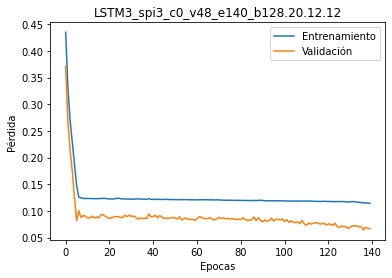

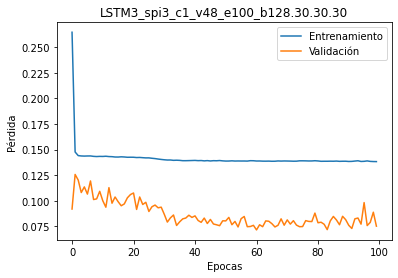

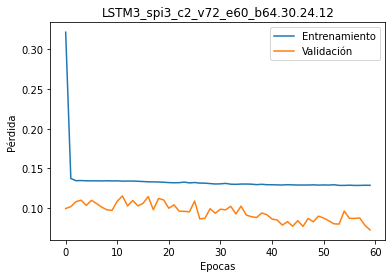

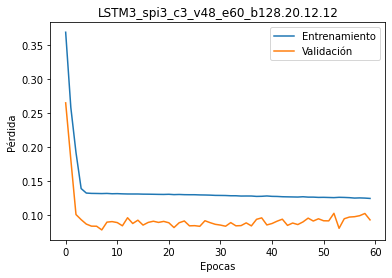

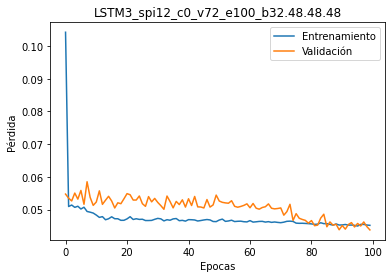

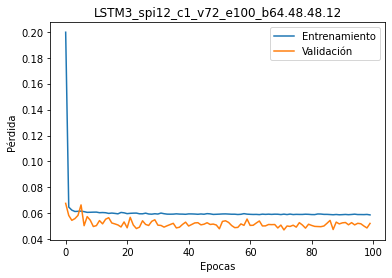

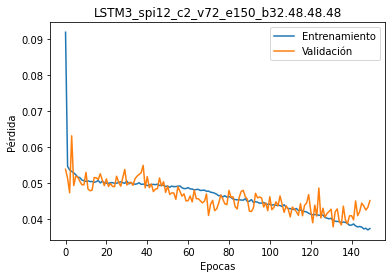

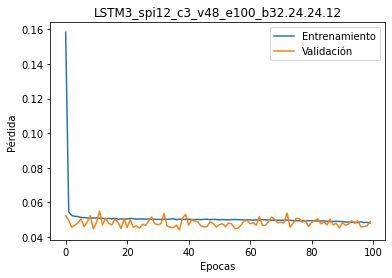

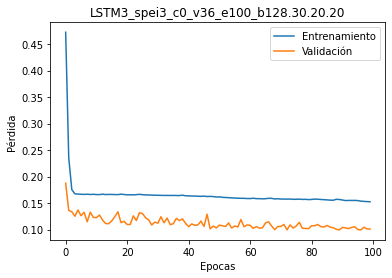

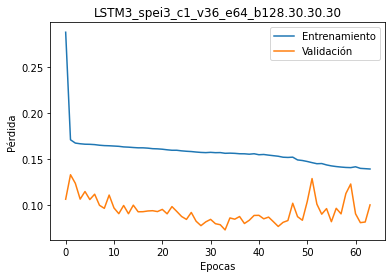

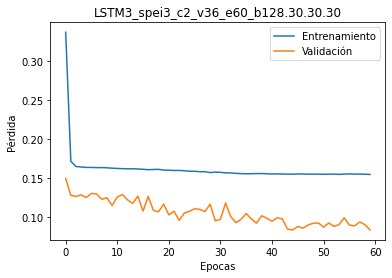

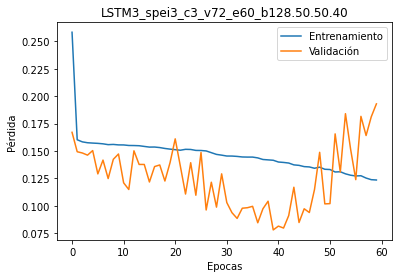

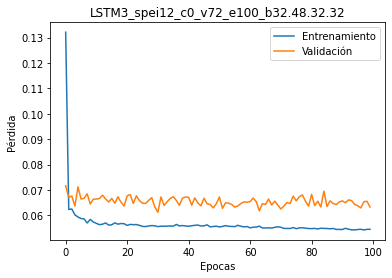

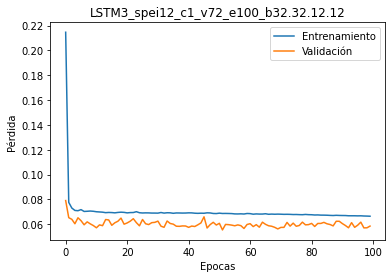

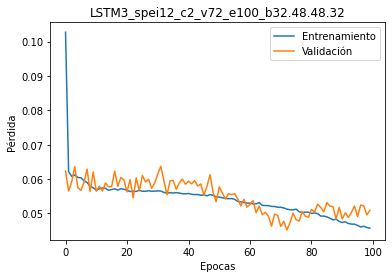

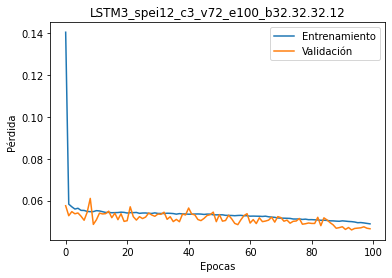

In [21]:
'''Cargar archivo con los clusters'''
cluster = pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/spi_spei/cluster_4.csv',  sep = ',', usecols = {'id', 'cluster'})

'''Definir el horizonte de la prediccion'''
hpred = 12  #Horizonte de Predicción 

error='mae'
'''Para SPI 3'''
'''modelo_lstm3(lind,lesc,cluster,lclu,ventana,epocas,x1,x2,x3,tbatch,error):'''
modelo_lstm3('spi',3,cluster,0,48,140,20,12,12,128,error)
modelo_lstm3('spi',3,cluster,1,48,100,30,30,30,128,error)
modelo_lstm3('spi',3,cluster,2,72,60,30,24,12,64,error)
modelo_lstm3('spi',3,cluster,3,48,60,20,12,12,128,error)
'''Para SPI 12'''
modelo_lstm3('spi',12,cluster,0,72,100,48,48,48,32,error)
modelo_lstm3('spi',12,cluster,1,72,100,48,48,12,64,error)
modelo_lstm3('spi',12,cluster,2,72,150,48,48,48,32,error)
modelo_lstm3('spi',12,cluster,3,48,100,24,24,12,32,error)
'''Para SPEI 3'''
modelo_lstm3('spei',3,cluster,0,36,100,30,20,20,128,error)
modelo_lstm3('spei',3,cluster,1,36,64,30,30,30,128,error)
modelo_lstm3('spei',3,cluster,2,36,60,30,30,30,128,error)
modelo_lstm3('spei',3,cluster,3,72,60,50,50,40,128,error)
'''Para SPEI 12'''
modelo_lstm3('spei',12,cluster,0,72,100,48,32,32,32,error)
modelo_lstm3('spei',12,cluster,1,72,100,32,12,12,32,error)
modelo_lstm3('spei',12,cluster,2,72,100,48,48,32,32,error)
modelo_lstm3('spei',12,cluster,3,72,100,32,32,12,32,error)